<a href="https://www.kaggle.com/code/paulharrald/waveform-inversion-starter?scriptVersionId=237056405" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Cell 1: Minimal CPU-Friendly Setup

import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
from scipy import ndimage

# Basic setup
print("Setting up minimal CPU-friendly environment...")
os.makedirs("outputs", exist_ok=True)

# Very minimal config
CONFIG = {
    'data_dir': Path("/kaggle/input/waveform-inversion/train_samples"),
    'test_dir': "/kaggle/input/waveform-inversion/test",
    'max_samples': 5,       # Very small sample size for CPU
    'max_files': 3,         # Very few files for quick testing
    'output_dir': "outputs"
}



Setting up minimal CPU-friendly environment...


Analyzing 3 sample files...
Input data shape: (500, 5, 1000, 70)
Output data shape: (500, 1, 70, 70)


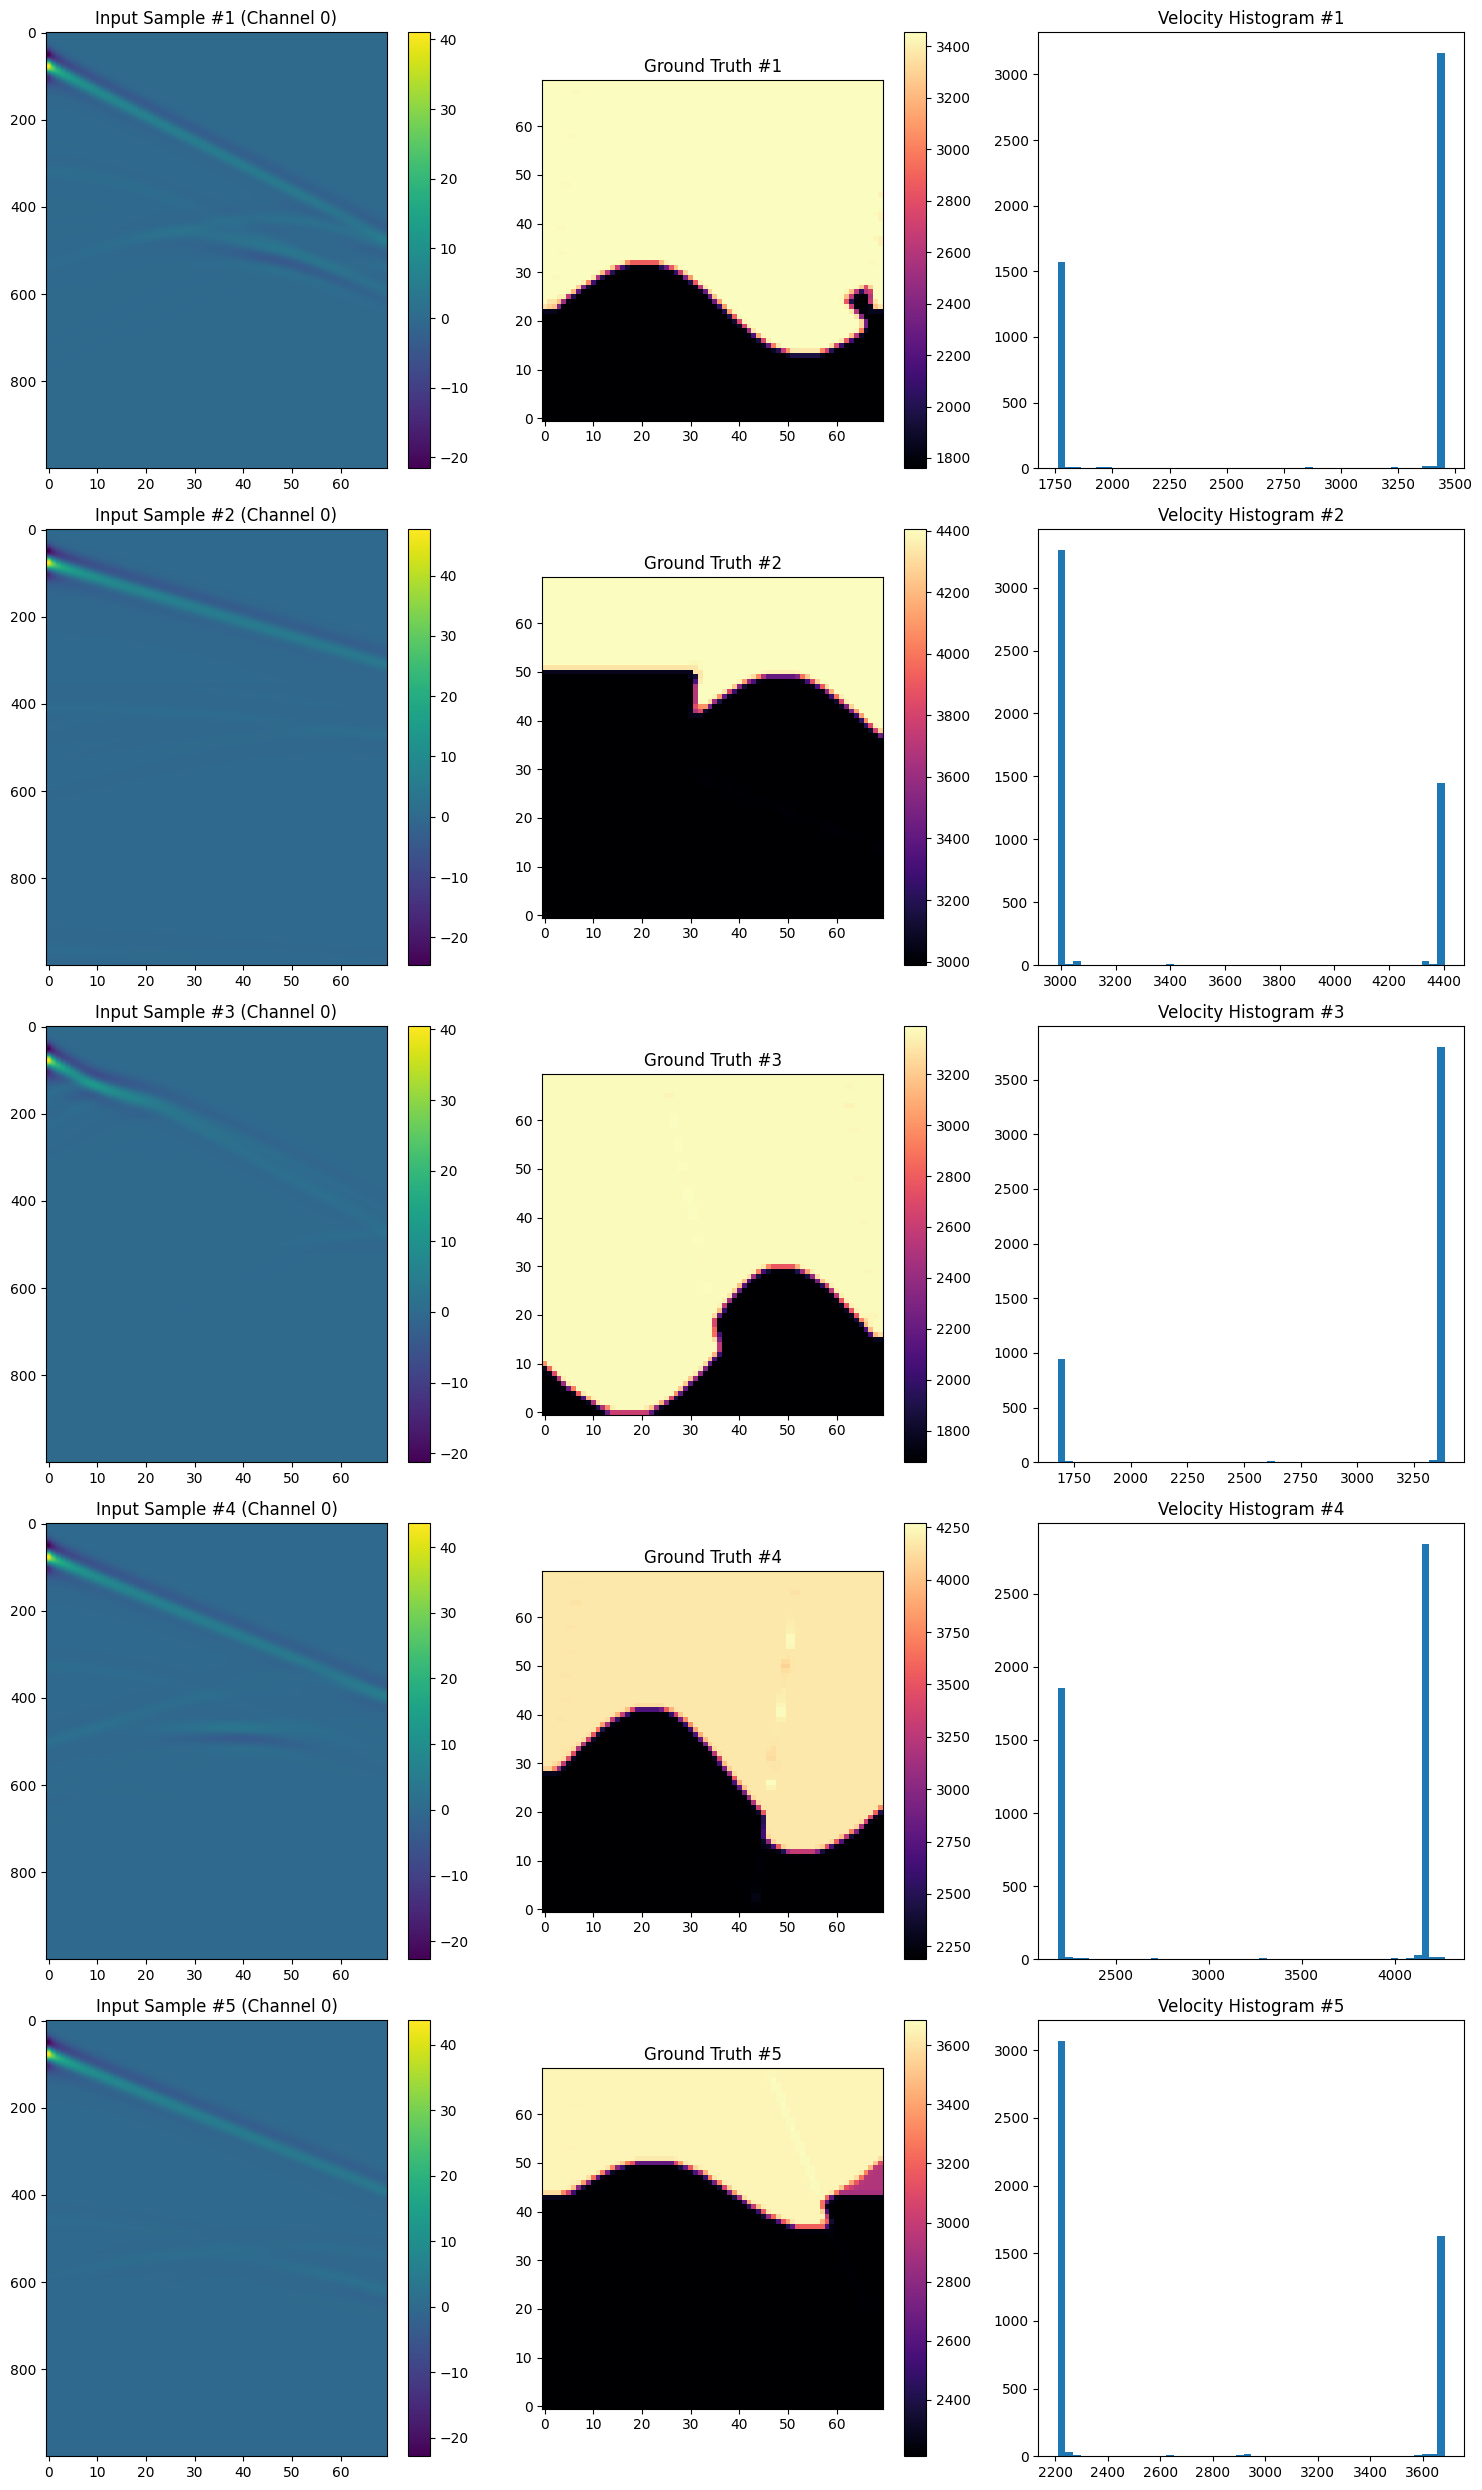

Otsu's threshold: 2810.89
Value statistics: min=1676.00, max=4404.00, mean=3089.54, median=3375.00


In [2]:
# Cell 2: Analyze Data and Extract Statistics

# Find a few sample files
input_files = sorted([f for f in CONFIG['data_dir'].rglob("*.npy") 
                      if 'seis' in f.name or 'data' in f.name])[:CONFIG['max_files']]
output_files = [Path(str(f).replace("seis", "vel").replace("data", "model")) 
                for f in input_files]

print(f"Analyzing {len(input_files)} sample files...")

# Extract key statistics and visualize samples
if len(input_files) > 0 and len(output_files) > 0:
    # Load first file
    input_data = np.load(input_files[0], mmap_mode='r')
    output_data = np.load(output_files[0], mmap_mode='r')
    
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")
    
    # Analyze a few samples
    num_samples = min(CONFIG['max_samples'], input_data.shape[0])
    
    # Statistics for thresholding
    all_values = []
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get samples
        x = input_data[i]
        
        # Handle different output dimensionality
        y = output_data[i]
        if len(y.shape) == 3 and y.shape[0] == 1:
            y = y[0]  # Extract first slice if 3D
        elif len(y.shape) > 2:
            y = y.reshape(-1, y.shape[-2], y.shape[-1])[0]
        
        # Collect values for statistics
        all_values.extend(y.flatten())
        
        # Visualize
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(x[0], cmap='viridis', aspect='auto')
        plt.title(f"Input Sample #{i+1} (Channel 0)")
        plt.colorbar()
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y, cmap='magma', origin='lower')
        plt.title(f"Ground Truth #{i+1}")
        plt.colorbar()
        
        # Create histogram of velocity values
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.hist(y.flatten(), bins=50)
        plt.title(f"Velocity Histogram #{i+1}")
        
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/sample_analysis.png")
    plt.show()
    
    # Calculate statistics
    values = np.array(all_values)
    min_val = np.min(values)
    max_val = np.max(values)
    mean_val = np.mean(values)
    median_val = np.median(values)
    
    # Find natural threshold using Otsu's method
    from skimage.filters import threshold_otsu
    try:
        otsu_threshold = threshold_otsu(values)
        print(f"Otsu's threshold: {otsu_threshold:.2f}")
    except:
        otsu_threshold = mean_val
        print(f"Using mean as threshold: {otsu_threshold:.2f}")
    
    print(f"Value statistics: min={min_val:.2f}, max={max_val:.2f}, mean={mean_val:.2f}, median={median_val:.2f}")
    
    # Save statistics for later use
    np.save(f"{CONFIG['output_dir']}/value_stats.npy", {
        'min': min_val,
        'max': max_val,
        'mean': mean_val,
        'median': median_val,
        'threshold': otsu_threshold
    })
else:
    print("No files found to analyze!")



Using threshold: 2810.89


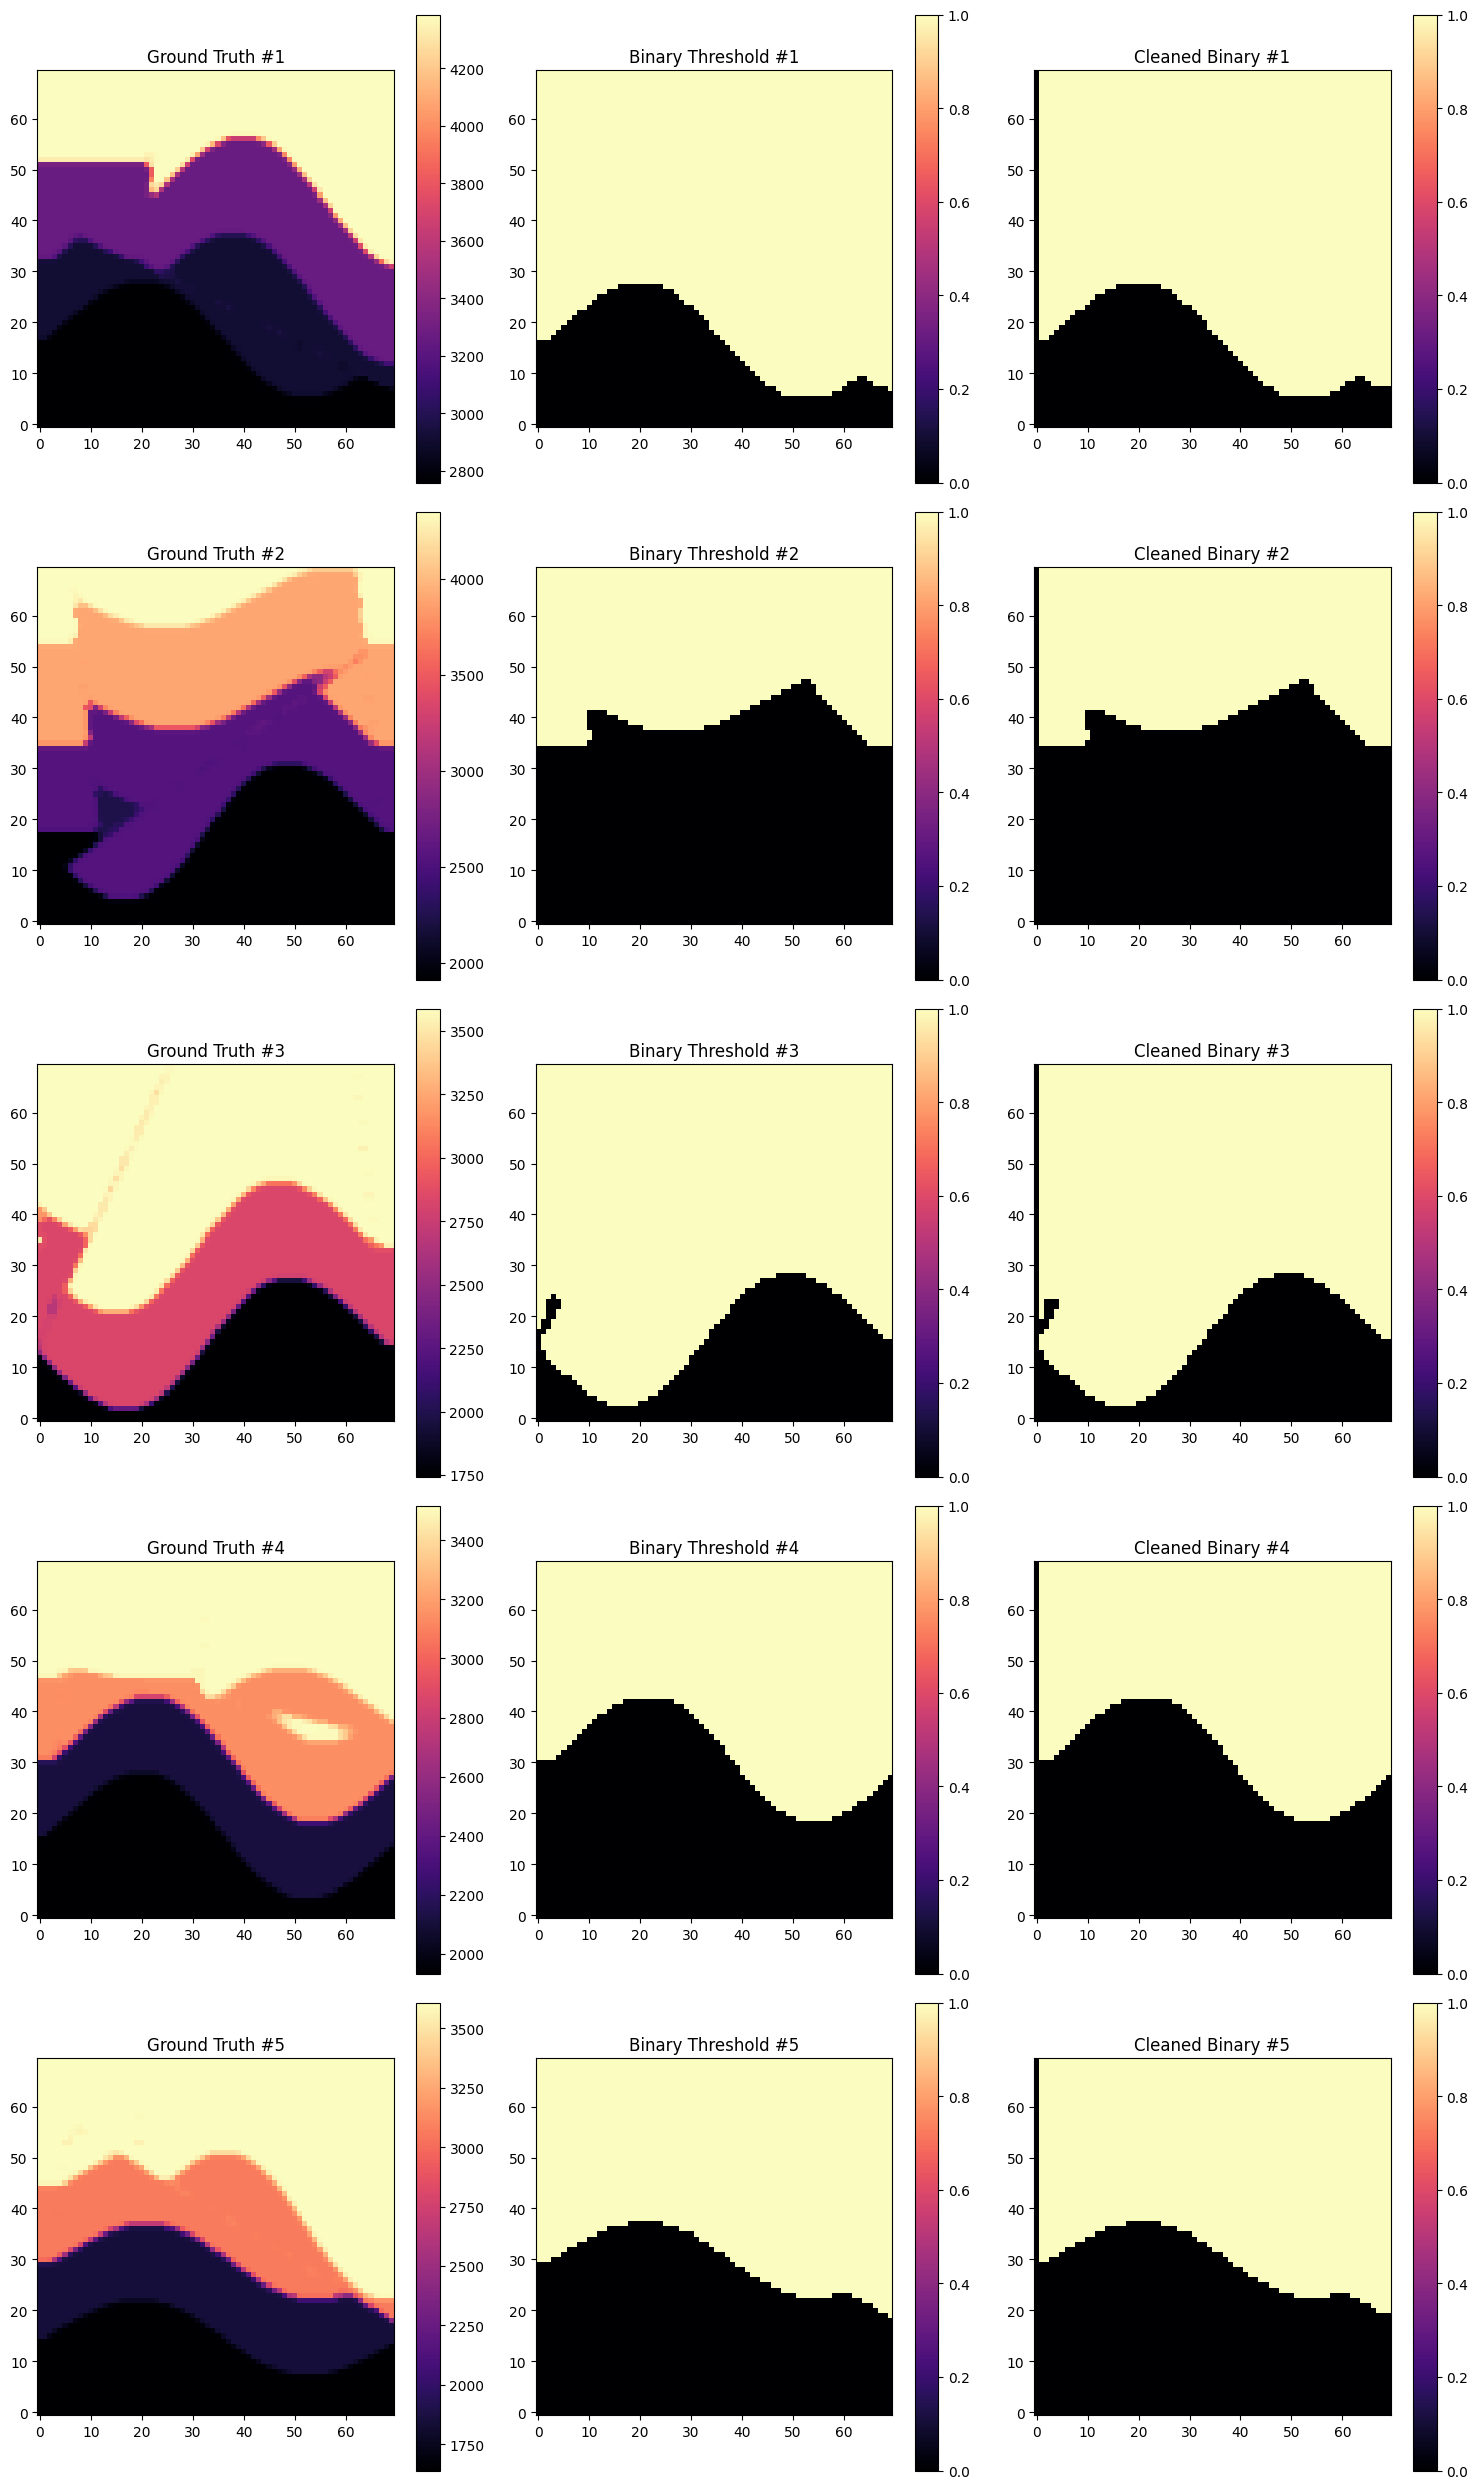

Binary accuracy: 0.9916


In [3]:
# Cell 3: Direct Threshold-Based Approach (No Training)

# Load statistics
try:
    stats = np.load(f"{CONFIG['output_dir']}/value_stats.npy", allow_pickle=True).item()
    threshold = stats['threshold']
    print(f"Using threshold: {threshold:.2f}")
except:
    threshold = 3000  # Fallback threshold
    print(f"Using fallback threshold: {threshold}")

# Test thresholding on validation samples
if len(input_files) > 1:
    # Use second file as validation
    val_input = np.load(input_files[1], mmap_mode='r')
    val_output = np.load(output_files[1], mmap_mode='r')
    
    # Process a few samples
    num_samples = min(CONFIG['max_samples'], val_input.shape[0])
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        # Get sample
        y = val_output[i]
        if len(y.shape) == 3 and y.shape[0] == 1:
            y = y[0]
        elif len(y.shape) > 2:
            y = y.reshape(-1, y.shape[-2], y.shape[-1])[0]
        
        # Create binary threshold version
        y_binary = (y > threshold).astype(np.float32)
        
        # Apply morphological operations to clean up (optional)
        y_cleaned = ndimage.binary_opening(y_binary, structure=np.ones((2, 2)))
        y_cleaned = ndimage.binary_closing(y_cleaned, structure=np.ones((2, 2)))
        
        # Visualize
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(y, cmap='magma', origin='lower')
        plt.title(f"Ground Truth #{i+1}")
        plt.colorbar()
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_binary, cmap='magma', origin='lower')
        plt.title(f"Binary Threshold #{i+1}")
        plt.colorbar()
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_cleaned, cmap='magma', origin='lower')
        plt.title(f"Cleaned Binary #{i+1}")
        plt.colorbar()
        
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/threshold_test.png")
    plt.show()
    
    # Calculate accuracy
    binary_accuracy = np.mean((y > threshold) == (y_cleaned > 0.5))
    print(f"Binary accuracy: {binary_accuracy:.4f}")



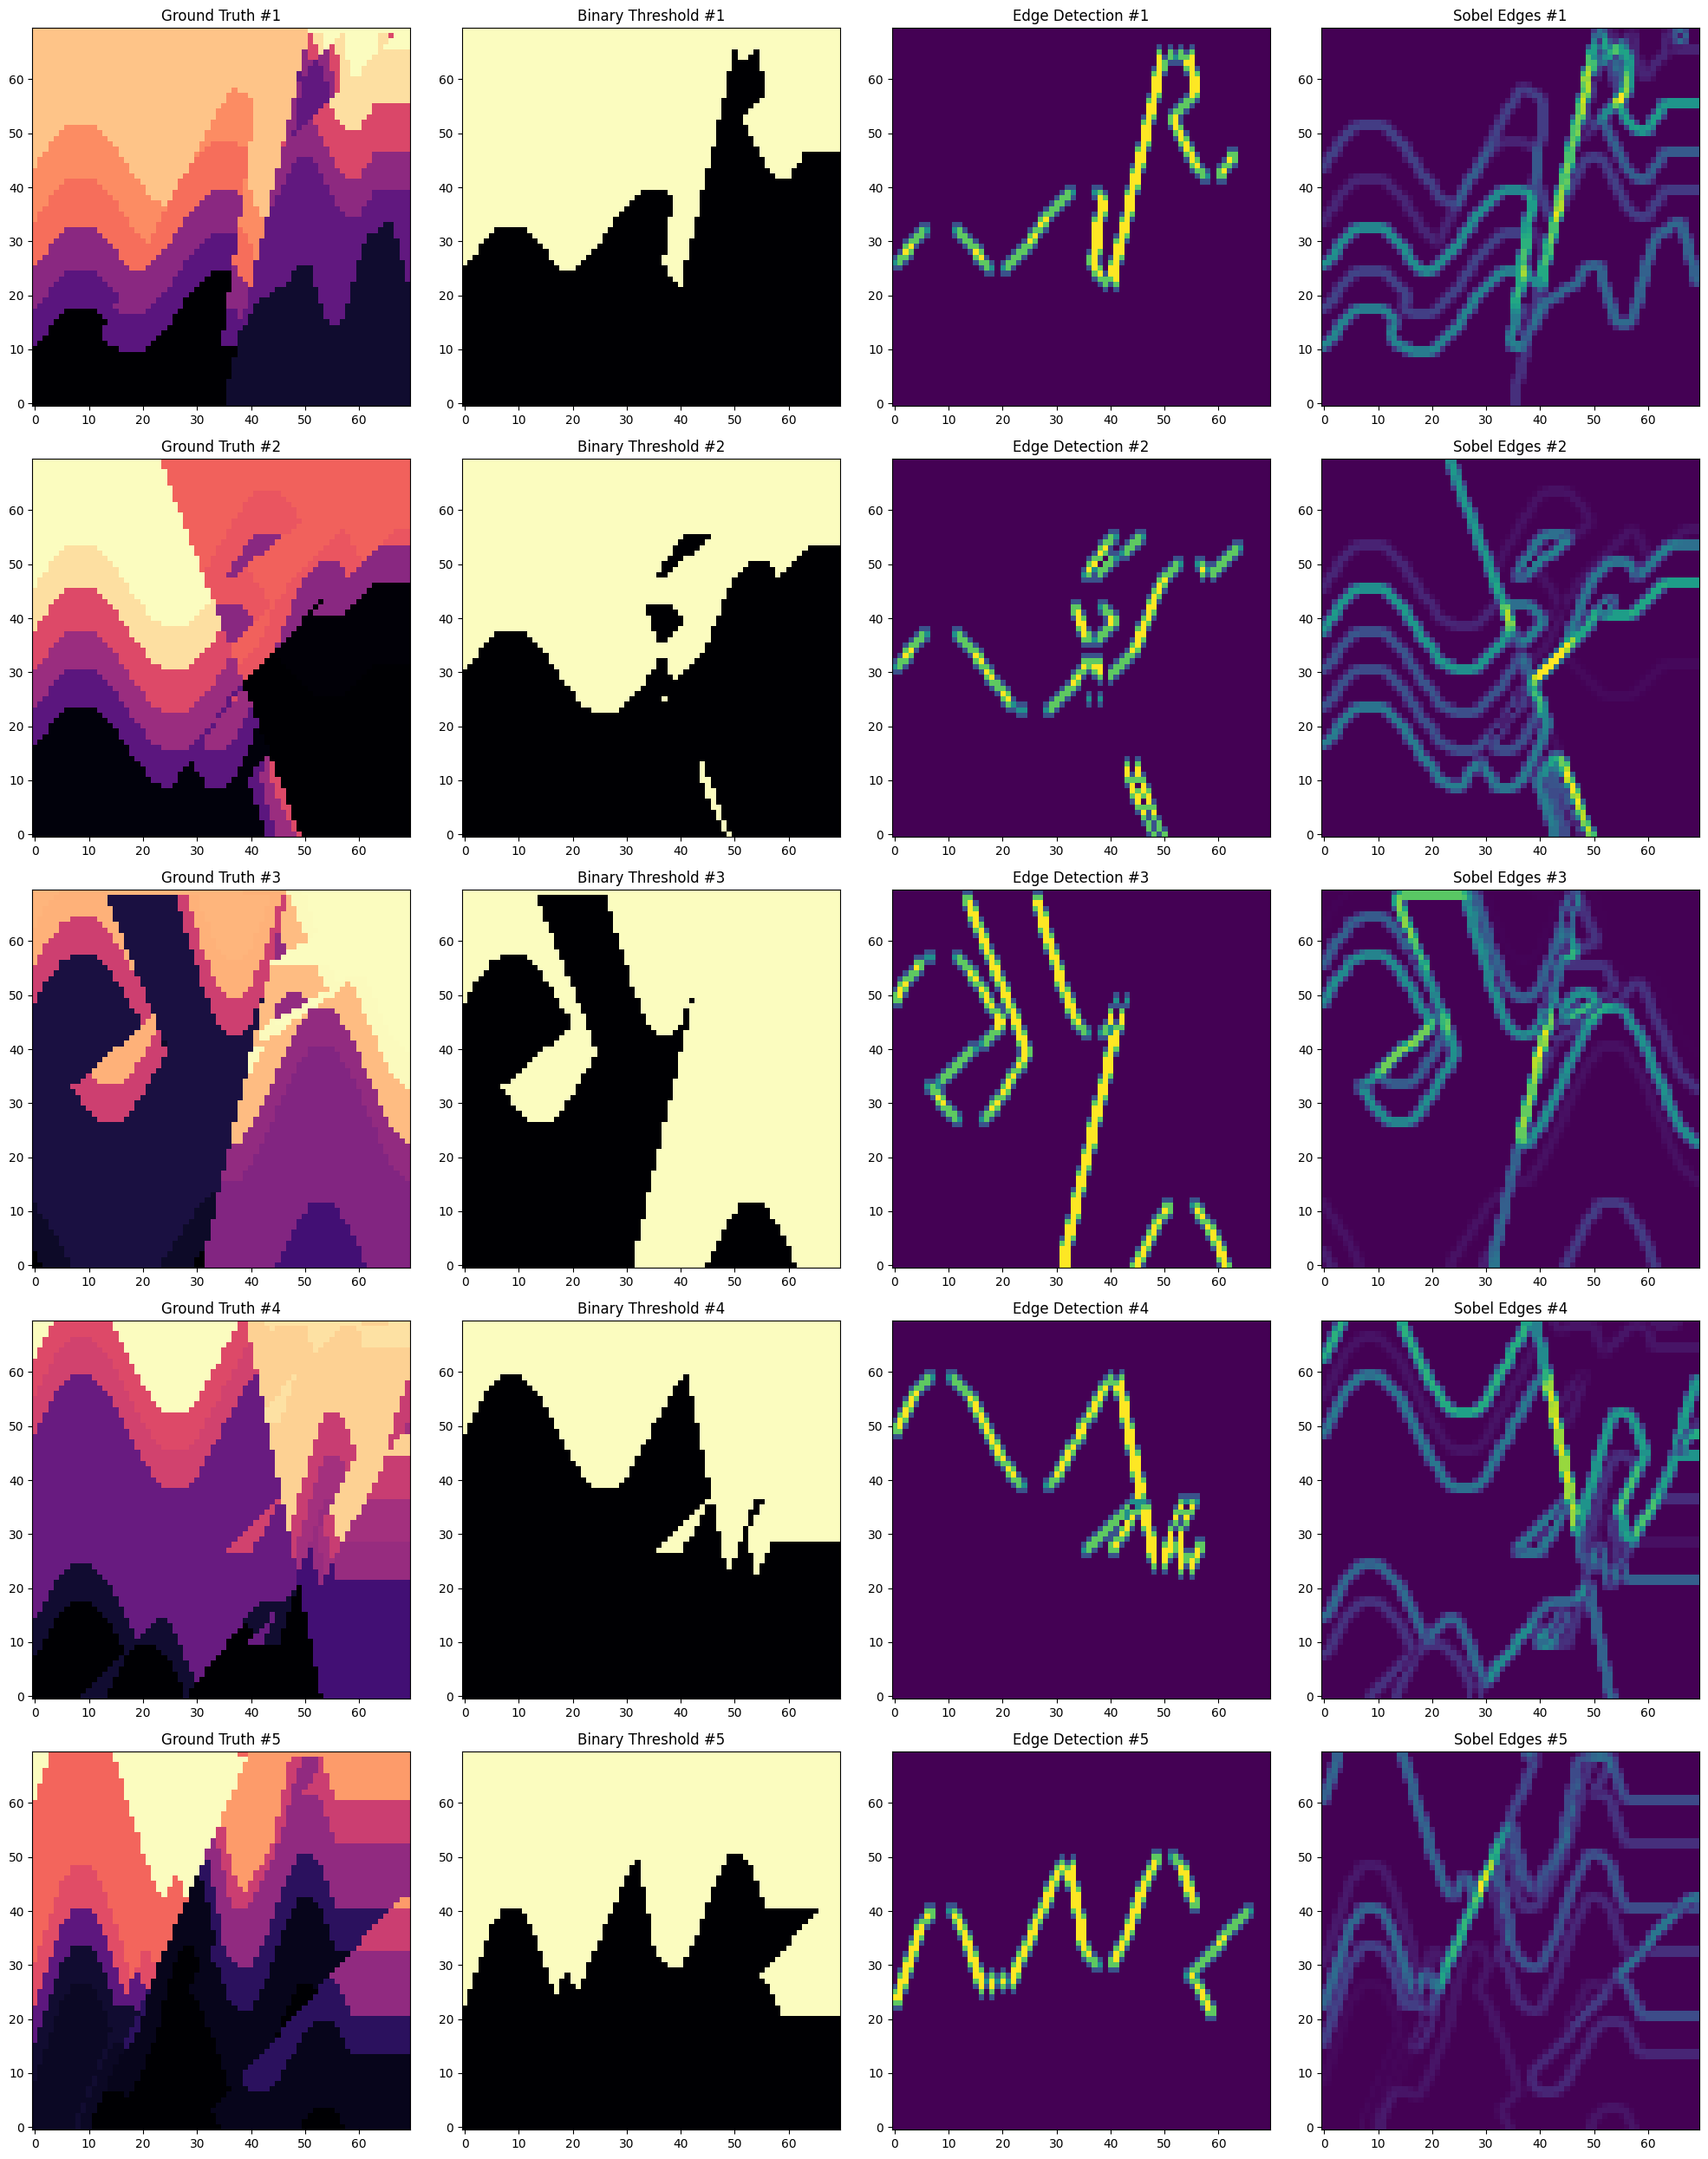

In [4]:
# Cell 4: Edge Detection Enhancement

# Test edge detection based enhancement
if len(input_files) > 1:
    # Use third file if available, otherwise second
    test_idx = 2 if len(input_files) > 2 else 1
    test_input = np.load(input_files[test_idx], mmap_mode='r')
    test_output = np.load(output_files[test_idx], mmap_mode='r')
    
    # Process a few samples
    num_samples = min(CONFIG['max_samples'], test_input.shape[0])
    
    plt.figure(figsize=(20, 5 * num_samples))
    
    for i in range(num_samples):
        # Get ground truth
        y = test_output[i]
        if len(y.shape) == 3 and y.shape[0] == 1:
            y = y[0]
        elif len(y.shape) > 2:
            y = y.reshape(-1, y.shape[-2], y.shape[-1])[0]
        
        # Create binary version
        y_binary = (y > threshold).astype(np.float32)
        
        # Apply edge detection
        edges = ndimage.sobel(y_binary)
        edges = np.abs(edges)
        edges = edges / np.max(edges)  # Normalize to [0,1]
        
        # Enhance edges in the binary image
        enhanced = y_binary.copy()
        enhanced[edges > 0.2] = 1.0  # Ensure edges are preserved
        
        # Sobel operator for smoother edge detection
        sx = ndimage.sobel(y, axis=0)
        sy = ndimage.sobel(y, axis=1)
        sobel = np.hypot(sx, sy)
        sobel = sobel / np.max(sobel)
        
        # Visualize
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(y, cmap='magma', origin='lower')
        plt.title(f"Ground Truth #{i+1}")
        
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(y_binary, cmap='magma', origin='lower')
        plt.title(f"Binary Threshold #{i+1}")
        
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(edges, cmap='viridis', origin='lower')
        plt.title(f"Edge Detection #{i+1}")
        
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(sobel, cmap='viridis', origin='lower')
        plt.title(f"Sobel Edges #{i+1}")
        
    plt.tight_layout()
    plt.savefig(f"{CONFIG['output_dir']}/edge_detection.png")
    plt.show()


In [5]:
# Cell 5: Generate Threshold-Based Submission
def process_test_file(filepath, threshold=3000):
    """Process a single test file using thresholding approach"""
    # Load data
    data = np.load(filepath)
    
    # Check shape and extract if needed
    if len(data.shape) == 4:  # (batch, channels, time, receivers)
        data = data[0]  # Use first sample if batched
    
    # Apply simple processing:
    # 1. Take mean across channels and time
    # We just need a 2D map that we can threshold
    processed = np.mean(data, axis=(0, 1))
    
    # 2. Apply threshold to create binary segmentation
    # Since we haven't seen the test data structure directly, 
    # we'll use a placeholder approach
    binary = (processed > np.mean(processed)).astype(np.float32)
    
    # 3. Resize to ensure correct dimensions (70x70)
    from skimage.transform import resize
    if binary.shape != (70, 70):
        binary = resize(binary, (70, 70), order=0, preserve_range=True)
    
    return binary

def generate_threshold_submission(test_dir, output_path, threshold=3000):
    """Generate submission using simple thresholding"""
    # Get test files
    test_files = sorted(glob.glob(os.path.join(test_dir, "*.npy")))
    print(f"Found {len(test_files)} test files")
    
    rows = []
    
    for i, filepath in enumerate(test_files):
        # Get file ID
        oid = os.path.splitext(os.path.basename(filepath))[0]
        if i == 0 or i == len(test_files) - 1 or (i+1) % (len(test_files)//5) == 0:  # 5 updates total
            percent = 100 * (i+1) / len(test_files)
            print(f"Progress: {percent:.1f}% ({i+1}/{len(test_files)})")
        
        # Process file
        binary_pred = process_test_file(filepath, threshold)
        
        # Format for submission (all rows, odd columns)
        for y in range(70):
            row_id = f"{oid}_y_{y}"
            row_data = binary_pred[y, 1:70:2]  # Extract odd-indexed columns
            rows.append([row_id] + row_data.tolist())
    
    # Create submission DataFrame
    columns = ["ID"] + [f"x_{i}" for i in range(1, 70, 2)]
    submission_df = pd.DataFrame(rows, columns=columns)
    
    # Save submission
    submission_df.to_csv(output_path, index=False)
    print(f"✅ Submission saved at: {output_path}")
    
    return submission_df

# Generate a very simple submission based on thresholding
try:
    stats = np.load(f"{CONFIG['output_dir']}/value_stats.npy", allow_pickle=True).item()
    threshold = stats['threshold']
except:
    threshold = 3000  # Fallback threshold

# Save directly to root directory for easier Kaggle submission access
submission_df = generate_threshold_submission(
    test_dir=CONFIG['test_dir'],
    output_path="submission.csv",  # Direct path for Kaggle
    threshold=threshold
)

# Also save a copy to outputs directory
submission_df.to_csv(f"{CONFIG['output_dir']}/threshold_submission.csv", index=False)

print("Submission preview (first 3 rows, limited columns):")
# Show just the first 3 rows and 5 columns
print(submission_df.iloc[:3, :5])

# Also show shape information
print(f"\nSubmission shape: {submission_df.shape} (rows × columns)")
print(f"First few columns: {', '.join(submission_df.columns[:5])}")
print(f"Last few columns: {', '.join(submission_df.columns[-3:])}")

Found 65818 test files
Progress: 0.0% (1/65818)
Progress: 20.0% (13163/65818)
Progress: 40.0% (26326/65818)
Progress: 60.0% (39489/65818)
Progress: 80.0% (52652/65818)
Progress: 100.0% (65815/65818)
Progress: 100.0% (65818/65818)
✅ Submission saved at: submission.csv
Submission preview (first 3 rows, limited columns):
               ID  x_1  x_3  x_5  x_7
0  000039dca2_y_0  0.0  0.0  0.0  0.0
1  000039dca2_y_1  0.0  0.0  0.0  0.0
2  000039dca2_y_2  0.0  0.0  0.0  0.0

Submission shape: (4607260, 36) (rows × columns)
First few columns: ID, x_1, x_3, x_5, x_7
Last few columns: x_65, x_67, x_69


In [ ]:
# Cell 6: More Advanced Pre-Processing (Optional)
# This cell demonstrates more advanced processing without training
def enhanced_process_test_file(filepath):
    """Process test file with more advanced techniques"""
    # Load data
    data = np.load(filepath)
    
    # Check shape and extract if needed
    if len(data.shape) == 4:  # (batch, channels, time, receivers)
        data = data[0]  # Use first sample if batched
    
    # 1. Apply time-dependent gain
    time_steps = data.shape[1]
    time_gain = np.linspace(1, 4, time_steps)
    gained_data = data.copy()
    for c in range(data.shape[0]):
        gained_data[c] = data[c] * time_gain[:, np.newaxis]
    
    # 2. Take mean across channels (after gain)
    channel_mean = np.mean(gained_data, axis=0)
    
    # 3. Calculate temporal variance (high variance indicates boundaries)
    temporal_variance = np.var(channel_mean, axis=0)
    
    # 4. Normalize and threshold
    normalized = (temporal_variance - np.min(temporal_variance)) / (np.max(temporal_variance) - np.min(temporal_variance))
    binary = (normalized > 0.5).astype(np.float32)
    
    # 5. Clean up with morphological operations
    binary = ndimage.binary_opening(binary, structure=np.ones((2, 2)))
    binary = ndimage.binary_closing(binary, structure=np.ones((3, 3)))
    
    # 6. Resize to ensure correct dimensions (70x70)
    from skimage.transform import resize
    if binary.shape != (70, 70):
        binary = resize(binary, (70, 70), order=0, preserve_range=True)
    
    return binary

def generate_enhanced_submission(test_dir, output_path):
    """Generate submission using enhanced processing"""
    # Get test files
    test_files = sorted(glob.glob(os.path.join(test_dir, "*.npy")))
    print(f"Found {len(test_files)} test files")
    
    rows = []
    
    for i, filepath in enumerate(test_files):
        # Get file ID
        oid = os.path.splitext(os.path.basename(filepath))[0]
        if i == 0 or i == len(test_files) - 1 or (i+1) % (len(test_files)//5) == 0:  # 5 updates total
            percent = 100 * (i+1) / len(test_files)
            print(f"Progress: {percent:.1f}% ({i+1}/{len(test_files)})")
        
        # Process file with enhanced method
        binary_pred = enhanced_process_test_file(filepath)
        
        # Format for submission (all rows, odd columns)
        for y in range(70):
            row_id = f"{oid}_y_{y}"
            row_data = binary_pred[y, 1:70:2]  # Extract odd-indexed columns
            rows.append([row_id] + row_data.tolist())
    
    # Create submission DataFrame
    columns = ["ID"] + [f"x_{i}" for i in range(1, 70, 2)]
    submission_df = pd.DataFrame(rows, columns=columns)
    
    # Save submission
    submission_df.to_csv(output_path, index=False)
    print(f"✅ Enhanced submission saved at: {output_path}")
    
    return submission_df

# Try the enhanced processing approach (optional)
try:
    # Save directly to the root directory for easier Kaggle submission
    enhanced_submission_df = generate_enhanced_submission(
        test_dir=CONFIG['test_dir'],
        output_path="enhanced_submission.csv"  # Direct path for Kaggle
    )
    
    # Also save a copy to outputs directory
    enhanced_submission_df.to_csv(f"{CONFIG['output_dir']}/enhanced_submission.csv", index=False)
    
    print("Enhanced submission preview (first 3 rows, limited columns):")
    print(enhanced_submission_df.iloc[:3, :5])
    
    # Also show shape information
    print(f"\nEnhanced submission shape: {enhanced_submission_df.shape} (rows × columns)")
    print(f"First few columns: {', '.join(enhanced_submission_df.columns[:5])}")
    print(f"Last few columns: {', '.join(enhanced_submission_df.columns[-3:])}")
    
except Exception as e:
    print(f"Enhanced submission generation failed: {e}")


In [ ]:
# Cell 7: Define Inference and Submission Functions

def generate_submission(models, test_dir, output_csv, stats, config):
    """Generate submission file with ensemble predictions"""
    # Ensure models are in eval mode
    for model in models:
        model.eval()
    
    device = next(models[0].parameters()).device
    rows = []
    
    # Get test files
    test_files = sorted(glob.glob(os.path.join(test_dir, "*.npy")))
    print(f"Found {len(test_files)} test files")
    
    with torch.no_grad():
        for i, filepath in enumerate(test_files):
            # Extract ID from filename
            oid = os.path.splitext(os.path.basename(filepath))[0]
            print(f"Processing file {i+1}/{len(test_files)}: {oid}")
            
            # Load waveform
            waveform = np.load(filepath)
            
            # Check input dimensions and reshape if needed
            if len(waveform.shape) == 4:  # (batch, sources, time, receivers)
                waveform = waveform[0]  # Take first sample if batch dimension exists
            
            # Apply gain (time-dependent)
            T = waveform.shape[1]  # Time dimension
            time = torch.linspace(0, 1, steps=T).unsqueeze(0).unsqueeze(-1)
            gain = (time ** 2).expand(1, T, waveform.shape[2]).numpy()
            waveform = waveform * gain
            
            # Normalize
            if stats:
                waveform = (waveform - stats['input_mean']) / (stats['input_std'] + 1e-6)
            
            # Convert to tensor
            waveform_tensor = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0)
            
            # Generate ensemble prediction
            preds = []
            
            # Basic predictions from each model
            for model in models:
                pred = model(waveform_tensor.to(device))
                preds.append(pred.cpu())
                
                # Optional test-time augmentation with flips
                if config['use_tta']:
                    # Horizontal flip
                    waveform_flipped = torch.flip(waveform_tensor, dims=[3])
                    pred_flipped = model(waveform_flipped.to(device))
                    pred_flipped = torch.flip(pred_flipped, dims=[3])
                    preds.append(pred_flipped.cpu())
            
            # Average ensemble predictions
            ensemble_pred = torch.mean(torch.stack(preds), dim=0)
            
            # Denormalize if using regression approach
            if stats and config['model_type'] != 'binary':
                ensemble_pred = ensemble_pred * (stats['output_std'] + 1e-6) + stats['output_mean']
            
            # Convert to numpy
            pred_np = ensemble_pred.squeeze().numpy()
            
            # Apply high-contrast enhancement for final submission
            enhanced_pred = apply_high_contrast(
                pred_np, 
                binary_threshold=0.5 if config['model_type'] == 'binary' else None
            )
            
            # Reshape if needed
            if enhanced_pred.ndim == 2:
                enhanced_pred = enhanced_pred.reshape(1, *enhanced_pred.shape)
            
            # Format for submission (all rows, odd-indexed columns)
            for y in range(70):
                row_id = f"{oid}_y_{y}"
                row_data = enhanced_pred[0, y, 1:70:2]  # Extract odd-indexed columns
                rows.append([row_id] + row_data.tolist())
    
    # Create submission DataFrame
    columns = ["ID"] + [f"x_{i}" for i in range(1, 70, 2)]
    submission_df = pd.DataFrame(rows, columns=columns)
    
    # Save submission
    submission_df.to_csv(output_csv, index=False)
    print(f"✅ Submission file saved at: {output_csv}")
    
    # Preview
    print("\nSubmission preview:")
    print(submission_df.head())
    
    return submission_df



In [ ]:
# Cell 8: Load Data and Prepare Datasets

# Find input and output files
data_dir = CONFIG['data_dir']
input_files = sorted([f for f in data_dir.rglob("*.npy") if 'seis' in f.name or 'data' in f.name])
output_files = [Path(str(f).replace("seis", "vel").replace("data", "model")) for f in input_files]

print(f"Found {len(input_files)} input files and {len(output_files)} output files")

# Check sample file to understand dimensions
if len(input_files) > 0 and len(output_files) > 0:
    in_sample = np.load(input_files[0], mmap_mode='r')
    out_sample = np.load(output_files[0], mmap_mode='r')
    print(f"Input sample shape: {in_sample.shape}")
    print(f"Output sample shape: {out_sample.shape}")
    
    # Example individual sample
    in_example = in_sample[0]
    out_example = out_sample[0]
    print(f"Single input shape: {in_example.shape}")
    print(f"Single output shape: {out_example.shape}")
    
    # Analyze values for determining binary threshold
    out_values = out_example[0].flatten()  # Assuming first channel if multi-channel
    print(f"Output min: {np.min(out_values)}, max: {np.max(out_values)}, mean: {np.mean(out_values)}")
    
    # Calculate histogram to detect natural threshold
    hist, bins = np.histogram(out_values, bins=50)
    peak_idx = np.argmax(hist)
    threshold_estimate = bins[peak_idx] + (bins[1] - bins[0])/2
    print(f"Estimated natural threshold: {threshold_estimate}")

# Train-validation split
train_in, val_in, train_out, val_out = train_test_split(
    input_files, output_files, test_size=CONFIG['val_size'], random_state=42
)

print(f"Training set: {len(train_in)} files")
print(f"Validation set: {len(val_in)} files")

# Calculate dataset statistics for normalization
print("Calculating dataset statistics...")
def calculate_dataset_stats(file_list, n_files=10, n_samples=100):
    all_samples = []
    files = file_list[:min(n_files, len(file_list))]
    for f in files:
        try:
            data = np.load(f, mmap_mode='r')
            idx = np.random.choice(data.shape[0], min(n_samples, data.shape[0]), replace=False)
            all_samples.append(data[idx])
        except Exception as e:
            print(f"Error processing {f}: {e}")
    
    if not all_samples:
        return 0.0, 1.0
    
    arr = np.concatenate(all_samples, axis=0)
    return float(np.mean(arr)), float(np.std(arr))

in_mean, in_std = calculate_dataset_stats(train_in)
out_mean, out_std = calculate_dataset_stats(train_out)
print(f"Input mean: {in_mean:.4f}, std: {in_std:.4f}")
print(f"Output mean: {out_mean:.4f}, std: {out_std:.4f}")

# Store statistics for later use
stats = {
    'input_mean': in_mean,
    'input_std': in_std,
    'output_mean': out_mean,
    'output_std': out_std
}

# Determine binary threshold based on output mean
binary_threshold = out_mean

# Create datasets
binary_mode = CONFIG['model_type'] == 'binary'

train_ds = SeismicDataset(
    train_in, train_out,
    gain=True,
    normalize=True,
    input_stats=(in_mean, in_std),
    output_stats=(out_mean, out_std),
    augment=True,
    binary_threshold=binary_threshold if binary_mode else None
)

val_ds = SeismicDataset(
    val_in, val_out,
    gain=True,
    normalize=True,
    input_stats=(in_mean, in_std),
    output_stats=(out_mean, out_std),
    augment=False,
    binary_threshold=binary_threshold if binary_mode else None
)

# Create data loaders
train_loader = DataLoader(
    train_ds,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Data preparation completed.")



In [ ]:
# Cell 9: Create Model and Loss Function

# Select model based on configuration
if CONFIG['model_type'] == 'physics':
    model = HighContrastInversionNet(in_channels=CONFIG['in_channels'], out_channels=CONFIG['out_channels'])
    criterion = HighContrastLoss(
        data_weight=CONFIG['data_weight'],
        edge_weight=CONFIG['edge_weight'],
        contrast_weight=CONFIG['contrast_weight']
    )
    print("Using Physics-Guided High-Contrast Model")
elif CONFIG['model_type'] == 'binary':
    model = BinaryVelocityNet(in_channels=CONFIG['in_channels'], out_channels=CONFIG['out_channels'])
    criterion = binary_velocity_loss
    print("Using Binary Velocity Model")
else:
    # Fallback to standard U-Net
    model = HighContrastInversionNet(in_channels=CONFIG['in_channels'], out_channels=CONFIG['out_channels'])
    criterion = nn.L1Loss()
    print("Using Standard U-Net Model")

# Move model to device
model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model created with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")

# Display model input/output shape
dummy_input = torch.randn(1, CONFIG['in_channels'], 70, 1000).to(device)
with torch.no_grad():
    dummy_output = model(dummy_input)
print(f"Model input shape: {dummy_input.shape}")
print(f"Model output shape: {dummy_output.shape}")



In [ ]:
# Cell 10: Start Training

# Train model
print(f"Starting training for {CONFIG['num_epochs']} epochs...")
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    valid_loader=val_loader,
    criterion=criterion,
    device=device,
    config=CONFIG
)

print("Training completed!")


# Cell 11: Generate Submission

# Optionally load the best model if not using the one in memory
model.load_state_dict(torch.load(f"{CONFIG['models_dir']}/best_model.pt"))

# For ensemble, we can use different model checkpoints
if CONFIG['use_ensemble']:
    # Look for different model checkpoints in the models directory
    model_files = glob.glob(f"{CONFIG['models_dir']}/best_model_*.pt")
    
    if len(model_files) > 1:
        print(f"Found {len(model_files)} models for ensemble")
        models = []
        
        for model_file in model_files:
            # Create model instance
            if CONFIG['model_type'] == 'binary':
                m = BinaryVelocityNet(in_channels=CONFIG['in_channels'], out_channels=CONFIG['out_channels'])
            else:
                m = HighContrastInversionNet(in_channels=CONFIG['in_channels'], out_channels=CONFIG['out_channels'])
            
            # Load checkpoint (handles both full checkpoint and state_dict)
            checkpoint = torch.load(model_file, map_location=device)
            if 'model_state_dict' in checkpoint:
                m.load_state_dict(checkpoint['model_state_dict'])
            else:
                m.load_state_dict(checkpoint)
            
            m = m.to(device)
            m.eval()
            models.append(m)
    else:
        # Just use single best model
        models = [model]
else:
    # Use single model
    models = [model]

# Generate submission
submission_df = generate_submission(
    models=models,
    test_dir=CONFIG['test_dir'],
    output_csv=CONFIG['submission_path'],
    stats=stats,
    config=CONFIG
)

print("Submission generation completed!")
